## Simulations for Poisson FOCuS

* Average Run Length plots
* Sine wave with exponential smoothing estimator for background
* Actual fermi data

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [16]:
import plotnine as p9
import pandas as pd
from IPython.display import Image

## Average Run Length Plot

Boxplot of three different significance levels (3$\sigma$, 5$\sigma$. 7$\sigma$)

In [8]:
np.random.seed(235)
λ=20
repeats = 3
significance_levels = [4.5, 8, 12.5]

output = pd.DataFrame(np.zeros((repeats, 3)))
output.columns = significance_levels

for threshold in significance_levels:

    for n in range(repeats):

        signal = stats.poisson.rvs(mu=λ, size=1000)
        significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal, λ=λ, μ_min=1, threshold=threshold, plot=False)
        output.loc[n, threshold] = stopping_time

run_lengths = output.melt(var_name="significance", value_name="run length")
run_lengths["count run length"] = run_lengths["run length"]*λ
run_lengths["time run length"] = run_lengths["count run length"] / 4000 #approximately how many photons per second

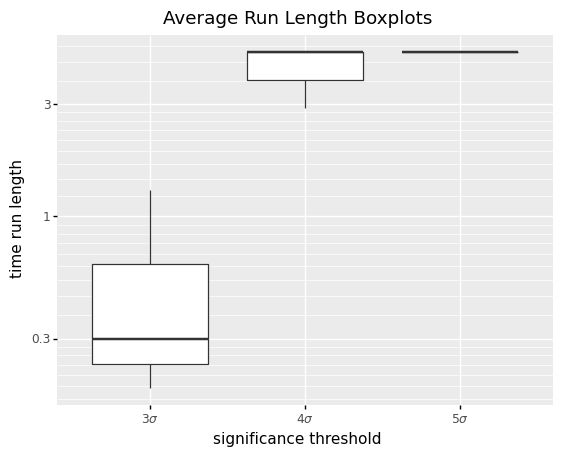

In [17]:
( p9.ggplot(run_lengths) 
+ p9.aes(x="factor(significance)", y="time run length") 
+ p9.geom_boxplot() 
+ p9.scale_x_discrete(name='significance threshold', labels=['$3\sigma$', '$4\sigma$', '$5\sigma$']) 
+ p9.scales.scale_y_log10()
+ p9.labels.ggtitle("Average Run Length Boxplots")).save(filename="plots/average_run_length_boxplots.png")

Image("plots/average_run_length_boxplots.png")

todo: boxplot y-axis units of seconds, tied to application

## Sine Wave Plots

Here, we model a scenario where our estimation of $\lambda$ is imperfect. To do this, we generate $\lambda$ as a log-sine wave, this having been chosen to comply well with Poisson boundary conditions and also capture the undulating nature of the background in many real world conditions. Then, we draw a signal independently $\sim \text{Poisson}(\lambda)$, and from that signal only re-estimate $\lambda(T)$ at each timestep $T$. We consider three estimation methods:

* Simple moving average, with a window $[T-w, T+w]$ centered around $T$
* Simple moving average, with a window $[T-w, T]$ not centered around $T$
* Simple exponential smoothing

Each method was given appropriate burn-in time at the beginning of the signal. The two latter methods each have the advantage of only using $t \leq T$ in the estimate of $\lambda(T)$, which is a desirable property to have when working with a real-time signal. Appropriate $w$ parameters for the simple moving average and $\alpha$ parameter for the simple exponential smoothing were chosen.

In [19]:
sinewave = np.cos(np.linspace(0, 4*np.pi, 10200))
λ = np.exp(1.4*(sinewave+1))
np.random.seed(365)
signal_extra = stats.poisson.rvs(λ)
signal = signal_extra[100:-100]

In [20]:
def simple_exponential_smoothing(signal, α):
    output = [signal[0]]
    estimate = signal[0]
    
    for point in signal[1:]:
        estimate = α*(estimate) + (1-α)*point
        output.append(estimate)
    
    return np.array(output)

def simple_moving_average(signal, w):
    signal_df = pd.DataFrame(signal)
    return signal_df.rolling(window=w, center=True).mean().values

In [21]:
sma_est = simple_moving_average(signal_extra, 100)[100:]

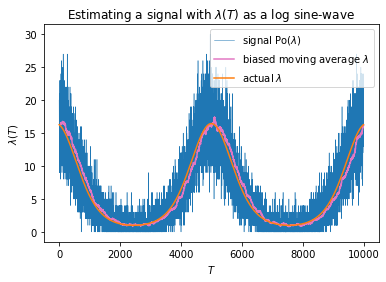

In [24]:
ses_est = simple_exponential_smoothing(signal_extra, 0.99)[100:-100]
sma_est = simple_moving_average(signal_extra, 100)[:-200]
plt.plot(signal, label="signal Po($\lambda$)", color="C0", linewidth=0.5)
plt.plot(sma_est, label="biased moving average $\lambda$", color="C6")
#plt.plot(ses_est, label="exponential smoothing $\lambda$", color="C3")
plt.plot(λ[100:-100], label="actual $\lambda$", color="C1")
plt.title("Estimating a signal with $\lambda(T)$ as a log sine-wave")
plt.xlabel("$T$")
plt.ylabel("$\lambda(T)$")
plt.legend()

plt.savefig('plots/signal_estimation.png', dpi = 150)
plt.show()

(this is the centered moving average on the graph. the uncentered moving average would just we the same line moved a bit to the right)

todo:
* check extent to which sine wave parameters mimic application
* figure out narrative for paper: robust centered window sometimes good, DES sometimes good, tradeoff, other methods can be *bad*
* get real data plots that mimic sine wave setting
* say hi to peppe again (paul will email)


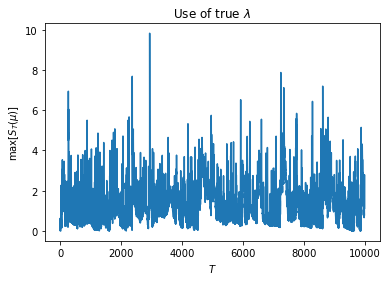

In [25]:
significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal, λ=λ[100:-100], μ_min=1, threshold=10000, plot=False)
plt.figure(figsize=(6, 4))
plt.plot(significance_array)
plt.title("Use of true $\lambda$")
plt.xlabel("$T$")
plt.ylabel("max[$S_T(\mu)$]")

plt.savefig('plots/fd_no_estimation.png', dpi = 150)
plt.show()

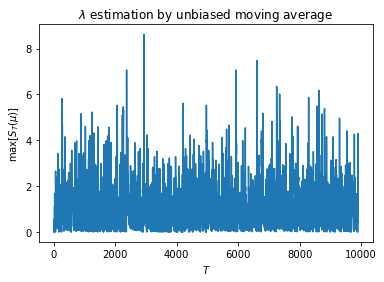

In [26]:
significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal[:-100], λ=sma_est[100:], μ_min=1, threshold=10000, plot=False)
plt.figure(figsize=(6, 4))
plt.plot(significance_array)
plt.title("$\lambda$ estimation by unbiased moving average")
plt.xlabel("$T$")
plt.ylabel("max[$S_T(\mu)$]")

plt.savefig('plots/fd_unbiased_estimation.png', dpi = 150)
plt.show()

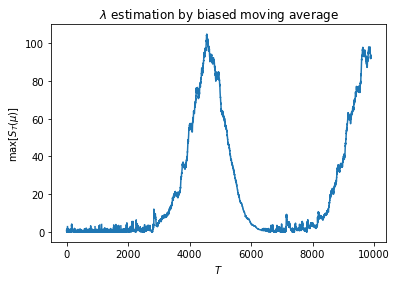

In [27]:
significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal[100:], λ=sma_est[100:], μ_min=1, threshold=10000, plot=False)
plt.figure(figsize=(6, 4))
plt.plot(significance_array)
plt.title("$\lambda$ estimation by biased moving average")
plt.xlabel("$T$")
plt.ylabel("max[$S_T(\mu)$]")

plt.savefig('plots/fd_biased_estimation.png', dpi = 150)
plt.show()

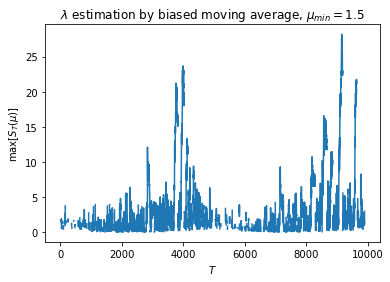

In [28]:
significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal[100:], λ=sma_est[100:], μ_min=1.5, threshold=10000, plot=False)
plt.figure(figsize=(6, 4))
plt.plot(significance_array)
plt.title("$\lambda$ estimation by biased moving average, $\mu_{min}=1.5$")
plt.xlabel("$T$")
plt.ylabel("max[$S_T(\mu)$]")

plt.savefig('plots/fd_biased_estimation_mumin.png', dpi = 150)
plt.show()

Here, we see a clear advantage to the centred window moving average method in terms of avoiding false positives. This is because simple exponential smoothing, or an uncentered simple moving average, introduces a lag into the estimate of $\lambda(T)$. When there is a consistent trend up, this lag will be consistently lower than the true $\lambda$ for a long time period. FOCuS interprets this as a collective anomaly in the actual signal. There is an advantage of methods that only use $t \leq T$ in estimating $\lambda(T)$ in designing a real-time algorithm, however when looking for collective anomalies it is important to ensure such methods do not introduce distortions of these kinds. Small distortions can be mostly fixed by choosing a value $\mu_{\text{min}} \geq 1$, as this prevents the build-up of very small anomalous evidence over very long time periods. However, there is still a pulse-like nature to the wave which indicates that we are more likely to get false anomaly excess detections when our background signal is trending up in a way our background estimation method has failed to adequately capture.

# Appendix: The FOCuS Code (fast version)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
   
class Curve:
    def __init__(self, k_T, lambda_1, t=-1):
        self.a = k_T
        self.b = -lambda_1
        self.t = t
        ## a log(mu) + b(mu-1)
        ## t contains time offset, because lambda_1 is incorporated into b.
    
    def __repr__(self):
        return f'{self.a}log(μ)-{-self.b}(μ-1), t={self.t}.'
    
    def evaluate(self, mu):
        return np.maximum(self.a*np.log(mu) + self.b*(mu-1), 0)
    
    def update(self, k_T, lambda_1):
        return Curve(self.a + k_T, -self.b + lambda_1, self.t-1)
    
    def ymax(self):
        return self.evaluate(self.xmax())
    
    def xmax(self):
        if self.a==0 and self.b==0:
            return 0
        else:
            return -self.a/self.b
    
    def is_negative(self):
        #returns true if slope at mu=1 is negative (i.e. no evidence for positive change)
        return (self.a + self.b) < 0
    
    def dominates(self, other_curve):
        self_root = -self.a/self.b #other non mu=1 root: the curve's "length"
        other_root = -other_curve.a/other_curve.b
        self_slope = self.a + self.b  #slope at mu=1: the curve's "height"
        other_slope = other_curve.a + other_curve.b
        return (self_root > other_root)and(self_slope > other_slope)
    
    def __add__(self, other_curve):
        #addition
        return Curve(self.a+other_curve.a, -self.b-other_curve.b, self.t+other_curve.t)
    
    def __sub__(self, other_curve):
        #subtraction
        return Curve(self.a-other_curve.a, -self.b+other_curve.b, self.t-other_curve.t)

## Notes on the $\mu_{\text{min}}$ calculation:

If a $\mu_{\text{min}} > 1$ is entered, the check to prune the curve is that:

$$a \log \mu_{\text{min}} + b (\mu_{\text{min}}-1) < 0$$

which simplifies to

$$a \frac{\log \mu_{\text{min}}}{\mu_{\text{min}}-1} < -b.$$

In order to avoid having to repeat logarithm calculations, the value $m :=\frac{\log \mu_{\text{min}}}{\mu_{\text{min}}-1}$ is calculated once at the beginning and stored. If no $\mu_{\text{min}}$ parameter is entered, the check is that the slope of the curve at $\mu=1$ is negative, i.e. $a + b< 0$. This can be achieved by a default $m = 1$ parameter and using the $am< -b$ check above.

In [5]:
def focus_step_fast_poisson(curve_difference_list, final_curve, max_list, X_t, λ, threshold=12.5, min_parameter=1):
    #min_parameter = log(μ_min)/(1- μ_min), avoids having to calculate logarithms
    
    #starting values:
    #curve_difference_list = []
    #final_curve = Curve(0, 0, t=0)
    #max_list = [0]

    pruning_required = True
    maxima_required = True
    threshold_met = False

    #start by performing an update:
    if -X_t*final_curve.b > λ*final_curve.a:
        #add another curve on
        new_final_curve = Curve(X_t, λ)
        curve_difference_list.append(final_curve)
        max_list.append(max_list[-1] + final_curve.ymax()) #requires evaluating a logarithm
        pruning_required=False
    else:
        #just update the final curve
        new_final_curve = final_curve.update(X_t, λ)


    while pruning_required:#check if curves prune each other out

        if curve_difference_list: #nonempty
            second_to_last_curve = new_final_curve+curve_difference_list[-1]
            if second_to_last_curve.dominates(new_final_curve):
                #prune out
                curve_difference_list.pop()
                max_list.pop()
                new_final_curve = second_to_last_curve
            else:
                #no more pruning checks required
                pruning_required=False
        
        else: pruning_required=False
            
    #evaluate whether rightmost curve is only nonzero on  1 < μ <  μ_min (min_parameter=1 corresponds to μ_min=1)
    if (new_final_curve.a * min_parameter < -new_final_curve.b):
        #empty out the algorithm
        curve_difference_list=[]
        max_list=[0]
        new_final_curve = Curve(0, 0, t=0)
        maxima_required=False
                
    #check maximum
    i = 1
    curve_being_checked = new_final_curve
    while maxima_required:
        
        curve_max = curve_being_checked.ymax() #requires evaluating a logarithm

        if curve_max+max_list[-i] < threshold:
            #no curve maxima meets the threshold
            maxima_required = False

        elif curve_max >= threshold:
            threshold_met=True
            maxima_required=False

        else: #iterate leftwards through curve list
            curve_being_checked = curve_being_checked + curve_difference_list[-i]
            i += 1

    return curve_difference_list, new_final_curve, max_list, threshold_met    
        
from copy import copy
def interpret(curve_difference_list, final_curve):
    #Takes the internals of the fast FOCuS algorithm and re-interprets them in the same format as the internals of the basic FOCuS algorithm
    global_max=final_curve.ymax()
    time_offset=final_curve.t
    curve_list=[final_curve]
    curve_being_checked = final_curve
        
    for i in range(1, len(curve_difference_list)+1):
        curve_being_checked = curve_being_checked + curve_difference_list[-i]
        
        curve_list.append(copy(curve_being_checked))
        
        if curve_being_checked.ymax() > global_max:
            global_max = curve_being_checked.ymax()
            time_offset = curve_being_checked.t
    curve_list.reverse()
    
    return curve_list, global_max, time_offset

def plot_curves(curve_list, threshold=25, t=0):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS Step")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{t}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot
    
    for c in curve_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.t+t+1}$')
    
    ax.axhline(0, color='C0')

    if curve_list:
        ax.legend(loc='upper left')
    return fig

In [6]:
def focus_fast_poisson(X, λ, μ_min=1, threshold=12.5, plot=False):
    
    significance_array = np.zeros(np.shape(X))
    
    if μ_min==1:
        min_parameter=1
    else:
        min_parameter = np.log(μ_min)/(μ_min-1)
    curve_difference_list=[]
    max_list=[0]
    final_curve=Curve(0, 0, t=0)
    
    if np.ndim(λ)==0:#scalar
        λ = np.full(X.shape, λ)
    
    for t in range(len(X)):
        curve_difference_list, final_curve, max_list, threshold_met  = focus_step_fast_poisson(curve_difference_list,
                                                                                       final_curve,
                                                                                       max_list,
                                                                                       X[t], λ[t],
                                                                                       threshold,
                                                                                       min_parameter)
        curve_list, global_max, time_offset = interpret(curve_difference_list, final_curve)
        significance_array[t] = global_max
        
        #print(curve_difference_list)
        
        if plot:
            clear_output(wait=True)
            curve_list, global_max, time_offset = interpret(curve_difference_list, final_curve)
            upper_bound = max_list[-1] + final_curve.ymax()
            plot_curves(curve_list, threshold=threshold, t=t)
            plt.hlines(upper_bound, xmin=1, xmax=4, color="black")
            plt.show()
            #print(curve_list)
        
        #print(max_list)
        if threshold_met:
            curve_list, global_max, time_offset = interpret(curve_difference_list, final_curve)
            significance, changepoint, stopping_time = global_max, t+time_offset+1, t
            return significance, changepoint, stopping_time, significance_array
    
    return 0, None, len(X)+1, significance_array

In [10]:
np.random.seed(42)
threshold=12.5
X = np.concatenate((stats.poisson(mu=1).rvs(size=5000), stats.poisson(mu=4).rvs(size=50)))
%timeit -n2 -r1 significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X, λ=1, μ_min=1, threshold=12.5, plot=False)

NameError: name 'Curve' is not defined